---
#**Visão Computacional**

## **Trabalho Final - Implementar uma CNN sem utilizar frameworks prontos de ML**
## **Aluno: Antonio Azambuja**

---

## **Objetivo**
O objetivo deste trabalho é estender o trabalho 3, criando uma Rede Neural Convolucional (CNN). Através deste trabaho, os conceitos de aprendizado, predição, *backpropagation* e gradiente descendente em CNNs serão fixados e entendidos. A rede não terá muita sofisticação, mas será capaz de resolver satisfatoriamente o problema de identificação de dígitos do MNIST.

---

---
##**Importando bibliotecas auxiliares**


**OBS1.:** *É necessário atualizar a biblioteca matplotlib para uma versão superior. Isso deve-se ao fato da nova versão ser necessária para algumas visualizações que serão realizadas.*

**OBS2.:** *Após o carregamento da nova versão da matplotlib, é necessário reiniciar o runtime do python.*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math

import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

import time
import torch

print("")
print("pytorch version")
print('{}'.format(torch.__version__))


import matplotlib
print("")
print("Matplotlib version")
print('{}'.format(matplotlib.__version__))

!pip install matplotlib --upgrade

print("")
print("Matplotlib version")
print('{}'.format(matplotlib.__version__))


Python version
3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
Version info.
sys.version_info(major=3, minor=8, micro=16, releaselevel='final', serial=0)

pytorch version
1.13.0+cu116

Matplotlib version
3.6.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Matplotlib version
3.6.2


---
##**Criando módulo utilitário para manipulação e visualização de imagens**

In [ ]:
class Utils:

  #definindo parametros globais
  PLOT_SX = 6 # tamanho do display em X
  PLOT_SY = 6 # tamanho do display em Y
  PLOT_FC_COLOR = 'w'  # cor de fundo branca


  #visualiza uma matriz 2d de rgb
  def drawImageRGB (img, title=''):
    plt.figure(figsize=[Utils.PLOT_SX, Utils.PLOT_SY], facecolor=Utils.PLOT_FC_COLOR)
    plt.title(title)
    plt.imshow(img)
    plt.show()


  #visualiza um atributo associado a uma escala de cores
  def drawImageAttr (img, title='', vmin=None, vmax=None, cmap="gray", colorbar=False, interpolation=None, norm=None):
    plt.figure(figsize=[Utils.PLOT_SX,Utils.PLOT_SY], facecolor=Utils.PLOT_FC_COLOR)
    plt.title(title)
    plt.imshow(img,cmap,vmin=vmin,vmax=vmax,interpolation=interpolation, norm=norm)
    if colorbar:
      plt.colorbar()
    plt.show()


  #visualiza uma matriz 2d de rgb em um eixo de subplot
  def drawImageRGB_grid(eixo, img, xlim=None, title=None, interpolation=None, aspect=None):
    eixo.set_title(title)
    eixo.imshow(img,interpolation=interpolation,aspect=aspect)
    eixo.set_xlim(xlim)


  #visualiza um atributo associado a uma escala de cores
  def drawImageAttr_grid (eixo, img, vmin=None, vmax=None, title='', cmap="gray", colorbar=False, interpolation=None, norm=None, aspect=None):
    eixo.set_title(title)
    img = eixo.imshow(img, cmap, vmin=vmin, vmax=vmax, interpolation=interpolation, norm=norm, aspect=aspect)
    if colorbar:
      plt.colorbar(img, ax=eixo)

  # Desenha o histograma de um array com controle total na geracao dos bins.
  def hist (v, bins, title="histogram"):
    plt.figure(figsize=(Utils.PLOT_SX*2,Utils.PLOT_SY))
    plt.title(title)
    n,b,p=plt.hist(v,bins)
    plt.xlim( [ bins.min(), bins.max()])
    plt.show()
    return n,b,p


  # Desenha o histograma de um array, dentro de um grid, com controle total na geracao dos bins.
  def hist_grid (eixo, v, bins, title="histogram"):
    h, b = np.histogram(v,bins)           #calcula histogram
    centers = np.zeros(h.shape[0])        # calcula o centro de cada bin
    for i,val in enumerate(bins[:-1]):
      centers[i] = (val + bins[i+1]) / 2
    eixo.set_title(title)
    #eixo.plot(centers,h)                  #desenha a funcao
    eixo.fill_between(centers,h)          #preenche a parte debaixo da curva
    eixo.set_xlim( [centers.min(), centers.max()] )
    return h,bins


  # Desenha o histograma de uma array. Os bins são gerados automaticamente a partir de v.min e v.max.
  def hist2 (v, nbins, lim, title="histogram"):
    plt.figure(figsize=(Utils.PLOT_SX*2,Utils.PLOT_SY))
    plt.title(title)

    #para forçar os limites exatos dos bins
    #n,bins,patches=plt.hist(v,nbins,range=lim)

    #para deixar os limites dos bins serem definidos a partir de v.min e v.max
    n,bins,patches=plt.hist(v,nbins)
    plt.xlim(lim)
    plt.show()
    return n,bins,patches


  def drawFunction_grid(eixo, x,ys, title=None, cores=None, fill=False, lw=None, xscale=True):

    multiplo = False 
    if ys.ndim > 1:
      multiplo = True
      fill = False    # se forem mais linhas, nao desenhar com fill

    if cores is not None:
      if multiplo:
        assert(len(cores) == ys.shape[0])
      else:
        assert(len(cores) == 1)
    else:
      if multiplo:
        cores = ["black"] * ys.shape[0]
      else:
        cores = [ "black" ]

    if not multiplo:
      linhas = np.reshape(ys, (1, ys.shape[0]))
    else:
      linhas = ys

    eixo.set_title(title)

    for l,c in list(zip(linhas,cores)):
      if fill:
        eixo.fill_between(x,l)
      else:
       eixo.plot(x, l, c, lw=lw)

    if xscale:
      eixo.set_xlim(x.min(), x.max())


  def drawFunction(x,ys, title=None, cores=None, fill=False, lw=None):

    multiplo = False 
    if ys.ndim > 1:
      multiplo = True
      fill = False    # se forem mais linhas, nao desenhar com fill

    if cores is not None:
      if multiplo:
        assert(len(cores) == ys.shape[0])
      else:
        assert(len(cores) == 1)
    else:
      if multiplo:
        cores = ["black"] * ys.shape[0]
      else:
        cores = [ "black" ]

    if not multiplo:
      linhas = np.reshape(ys, (1, ys.shape[0]))
    else:
      linhas = ys

    plt.title(title)

    for l,c in list(zip(linhas,cores)):
      if fill:
        plt.fill_between(x,l)
      else:
       plt.plot(x, l, c, lw=lw)

    plt.xlim(x.min(), x.max())


  def getMinMax(v):
    return np.min(v), np.max(v) 


  # cria uma nova imagem com a luminância
  def lum(img):
    return np.dot(img,[0.2126,0.7152,0.0722])


  def printImageInfo(img,title=None):
    if title is not None:
      print("----------- [", title, "] -------------------")
    else:
      print("------------ [ IMAGE INFO ] -------------------")
    print("[ SHAPE ]", img.shape)
    tp = img.dtype
    if img.ndim == 3:
      nc = img.shape[2]
    else:
      nc = 1
    h = img.shape[0]
    w = img.shape[1]
    print (f'[ DIMENSÕES ] w={w}, h={h}, numero de canais de cor = {nc}')
    print (f'[ CARACTERÍSTICAS ] dtype = {tp}, min={np.amin(img)}, max={np.amax(img)}, median={np.median(img)}')
    print("-----------------------------------------------")


  def printMessage(msg):
    print("---------------------------------------------------")
    print(msg)
    print("---------------------------------------------------")


  def printGPUInfo():
    iscuda       = torch.cuda.is_available()
    print(f"[ POSSUI GPGPUs? ] {iscuda}")
    if iscuda:
      device_count = torch.cuda.device_count()
      device_id    = torch.cuda.current_device()
      device_name  = torch.cuda.get_device_name(id)
      print(f"[ QUANTAS GPGPUs? ] {device_count}")
      print(f"[ ID DA GPGPU CORRENTE ] {device_id}")
      print(f"[ MODELO GPGPU ] {device_name}")



  def getTensorDevice():
    ret = 'cpu'
    iscuda       = torch.cuda.is_available()
    if iscuda:
      ret = 'cuda'
    return ret


# extracted from: https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/metrics/_classification.py#L1825
  def classification_report_2_str(data_dict):
    """Build a text report showing the main classification metrics.
    Read more in the :ref:`User Guide <classification_report>`.
    Parameters
    ----------
    report : string
        Text summary of the precision, recall, F1 score for each class.
        Dictionary returned if output_dict is True. Dictionary has the
        following structure::
            {'label 1': {'precision':0.5,
                         'recall':1.0,
                         'f1-score':0.67,
                         'support':1},
             'label 2': { ... },
              ...
            }
        The reported averages include macro average (averaging the unweighted
        mean per label), weighted average (averaging the support-weighted mean
        per label), and sample average (only for multilabel classification).
        Micro average (averaging the total true positives, false negatives and
        false positives) is only shown for multi-label or multi-class
        with a subset of classes, because it corresponds to accuracy otherwise.
        See also :func:`precision_recall_fscore_support` for more details
        on averages.
        Note that in binary classification, recall of the positive class
        is also known as "sensitivity"; recall of the negative class is
        "specificity".
    """

    non_label_keys = ["accuracy", "macro avg", "weighted avg"]
    y_type = "binary"
    digits = 2

    target_names = [
        "%s" % key for key in data_dict.keys() if key not in non_label_keys
    ]

    # labelled micro average
    micro_is_accuracy = (y_type == "multiclass" or y_type == "binary")

    headers = ["precision", "recall", "f1-score", "support"]
    p = [data_dict[l][headers[0]] for l in target_names]
    r = [data_dict[l][headers[1]] for l in target_names]
    f1 = [data_dict[l][headers[2]] for l in target_names]
    s = [data_dict[l][headers[3]] for l in target_names]

    rows = zip(target_names, p, r, f1, s)

    if y_type.startswith("multilabel"):
        average_options = ("micro", "macro", "weighted", "samples")
    else:
        average_options = ("micro", "macro", "weighted")

    longest_last_line_heading = "weighted avg"
    name_width = max(len(cn) for cn in target_names)
    width = max(name_width, len(longest_last_line_heading), digits)
    head_fmt = "{:>{width}s} " + " {:>9}" * len(headers)
    report = head_fmt.format("", *headers, width=width)
    report += "\n\n"
    row_fmt = "{:>{width}s} " + " {:>9.{digits}f}" * 3 + " {:>9}\n"
    for row in rows:
        report += row_fmt.format(*row, width=width, digits=digits)
    report += "\n"

    # compute all applicable averages
    for average in average_options:
        if average.startswith("micro") and micro_is_accuracy:
            line_heading = "accuracy"
        else:
            line_heading = average + " avg"

        if line_heading == "accuracy":
            avg = [data_dict[line_heading], sum(s)]
            row_fmt_accuracy = "{:>{width}s} " + \
                    " {:>9.{digits}}" * 2 + " {:>9.{digits}f}" + \
                    " {:>9}\n"
            report += row_fmt_accuracy.format(line_heading, "", "",
                                              *avg, width=width,
                                              digits=digits)
        else:
            avg = list(data_dict[line_heading].values())
            report += row_fmt.format(line_heading, *avg,
                                     width=width, digits=digits)
    return report



---
##**Convolutional Neural Networks (CNNs)**


---
### **O que é uma rede neural convolucional (CNN) e qual seu propósito?**

Alguns domínios de problemas de *machine learning* (**ML**) são fortemente caracterizados por sua estrutura topológica –  ou seja, as relações de vizinha entre as informações – e por sua dimensionalidade.

Um exemplo bastante claro disso são problemas que lidam com imagens. Estas são fortemente definidas pela relação de vizinhança entre pixels e pela sua dimensão espacial (2D). Arquiteturas de redes neurais MPL são utilizadas com relativo sucesso para resolver problemas desse tipo, mas vislumbrou-se com as redes CNN uma forma explícita de tomar proveito dessas características e atingir, potencialmente, melhores resultados.

A ideia principal de uma CNN é utilizar os conceitos de filtros convolucionais e de multi-escala (conceitos bem conhecidos e dominados nas áreas de *Tratamento de Imagens*, *Visão Computacional* e *Teoria dos Sinais*) para a extração automática de atributos locais e globais de uma imagem.

A forma como as CNNs funcionam (que será vista mais à frente) oferece a elas as seguintes características: 

 - **Foco** – a rede se utiliza das relações locais de vizinha

 - **Multi-escala** – a rede consegue analisar informações distantes entre si de forma estruturada  
 
 - **Menor quantidade de parâmetros** de treinamento quando comparada a uma abordagem tradicional (vários níveis de FC)


Uma CNN é uma generalização de uma **Fully Connected Network (FCN)**, podendo ter conexões esparsas entre neurônios e compartilhamento de pesos.


### **Como funciona?**

O uso mais significativo de CNNs é para resolver problemas de classificação de imagens. Tipicamente, são utilizadas 2 tipos de camadas para compor uma rede CNN:

 - **Camada convolucional** – contém os filtros convolucionais (kernels) e é responsável por fazer a redução de dimensionalidade, misturar canais e alterar a escala de observação através de *pooling*
 
 - **Camada FC** – responsável por realizar a classificação final 

Várias camadas convolucionais são encadeadas seguidas de uma camada FC que realiza a classificação


---
### **Estrutura da camada convolucional**
A figura seguinte ilustra a estrutura de uma camada convolucional.


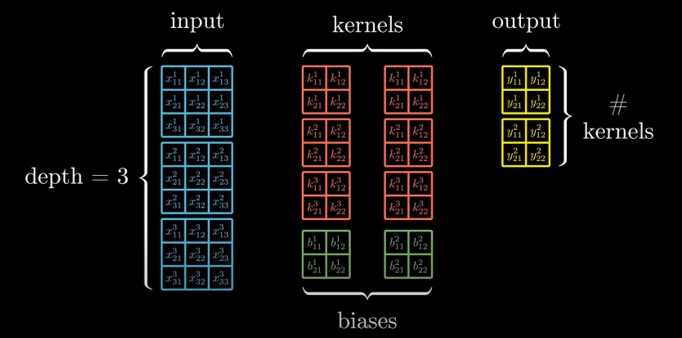

Na figura, podemos perceber 4 matrizes distintas: 

 - ***input*** é a camada de entrada que está conectada à camada convolucional

 - ***kernels*** são os pesos a serem aprendidos pela rede e responsáveis pela extração de atributos

 - ***biases*** são os pesos aditivos a serem aprendidos

 - ***output*** são os resultados das convoluções do *input* com os *kernels*

#### **Tamanhos**
O *input* possui tamanho (*minibatch*, depth, nx, ny), onde *minibatch* é o tamanho do *minibatch* (não está contemplado na ilustração acima),  *depth* é a quantidade de canais da imagem, *nx* e *ny* são a altura e a largura de cada imagem.

A camada convolucional deve ser parametrizada de forma que seja possível definir os tamanhos para *kernels*, *biases* e *output*.

Sendo assim, ela precisa ser parametrizada por:

 - tamanho da entrada sem o *minibatch* - (depth, nx, ny)

 - quantidade de *kernels* - (#kernels)

 - altura e largura de um *kernel* - (k)

A matriz *kernels* possui a forma (#kernels, depth, k, k).

A matriz *biases* possui a forma (#kernels, nx-k+1,ny-k+1).

A matriz output possui a forma (*minibatch*, #kernels, nx-k+1 , ny-k+1).

Uma função de ativação é aplicada a *output* antes de ser enviada para camada subsequente.

Ao resultado da função de ativação é aplicada uma operação de *pooling*.



---
### ***Forward***
Vamos simplificar nossa figura explicativa, renomeando as matrizes.

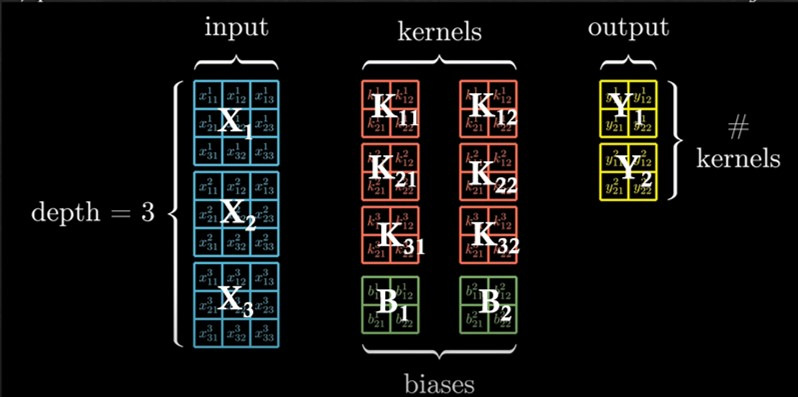

Agora, podemos escrever os cálculos realizados durante o forward da seguinte forma:

$$Y_i = \sum_{j=1}^{depth} (X_j \star K_{ji})+ B_i$$

onde o operador binário $\star$ denota a operação de correlação 2d entre sinais discretos.

Vale mencionar que à fórmula acima podem ser  adicionados outros parâmetros que controlam saltos (stride) dos *kernels* durante a correlação e afetam o tamanho final de cada saída $Y_i$.

Uma consequência da própria operação de correlação é o compartilhamento de pesos, ou seja, os mesmos pesos de um kernel são aplicados a diferentes porções da imagem de entrada. Isso traz vantagens, tais como:
 - diminui a quantidade de parâmetros do modelos 

 - diminui o tempo de treinamento

 - propicia melhor generalização



---
### ***Backward***

---

##**Diagramas de Classes**


O diagrama de classes que representa as camadas é:


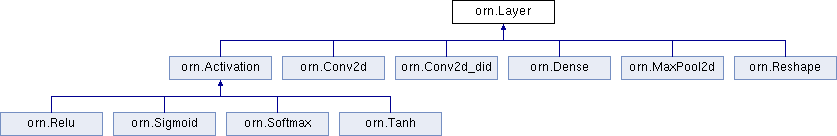






E o diagrama de classes do erro é:

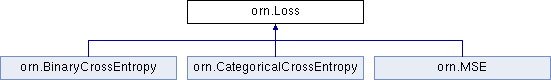

---

## **APIs**

### **Network**

Network é a classe que representa a rede neural e faz o treinamento. Sua API é:

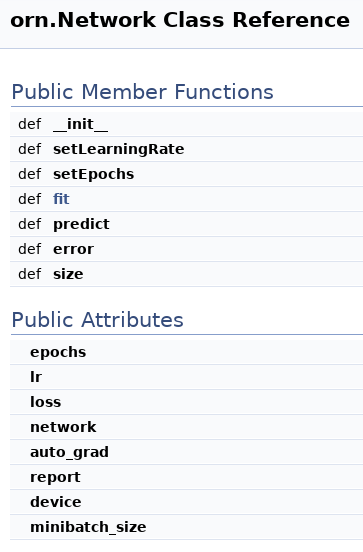

---

### **Loss**

Loss é a classe base que representa as funções de perda. Sua API é:

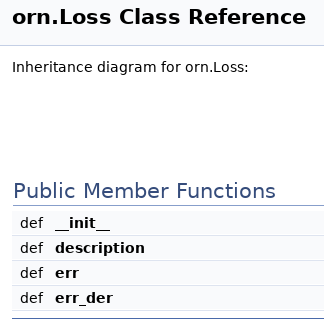

---

## **Layer**
Layer e a classe base das camadas da rede neural. Sua API é:




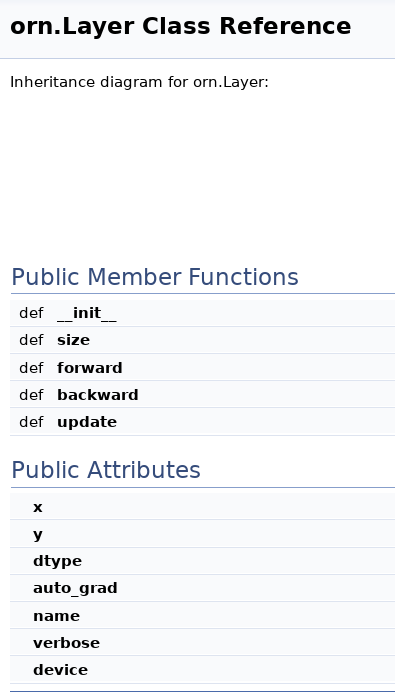


---

## **Classes auxiliares**
E outras classes auxiliares utilizadas pela Network para cálculo de métricas de erro e visualização do treinamento:
 - **Report**
 - **ClassificationTransforms**
 - **Categorical**




---
## **Implementação**

---

### **Classes Abstratas**

---
#### **class Layer**
Classe abstrata que define a API de uma camada e algumas inicializações comuns a todas as camadas.

In [ ]:
#########################################################################
class Layer:

  def __init__(self, name="Default", verbose=False, auto_grad=False, device='cpu', dtype=torch.float32):
    self.x = None 
    self.y = None
    self.dtype = dtype
    self.auto_grad = auto_grad
    self.name      = name
    self.verbose   = verbose
    self.device    = device


  def size(self):
    raise NotImplementedError


  def forward(self, x):
    if self.verbose:
      print(f"[ {self.name} ] [FWD]")
      print(f"x.shape = ", x.shape)
    #raise NotImplementedError


  def backward(self, y_grad, lr):
    if self.verbose:
      print(f"[ {self.name} ] [BCW]")
      print(f"y_grad = ({y_grad.shape})")
      print(f"x.shape = ({self.x.shape})")
    #raise NotImplementedError


  def update(self, lr):
    if self.verbose:
      print(f"[ UPDATE ] layer={self.name}")
      print(f"x = ({self.x.shape})")
    #raise NotImplementedError




---
#### **class Activation**

In [ ]:
#########################################################################
class Activation(Layer):


  def __init__(self, af, af_der, verbose=False, name="Activation", auto_grad=False, device='cpu', dtype=torch.float32):
    super().__init__(name=name, verbose=verbose, auto_grad=auto_grad, device=device, dtype=dtype)
    self.af = af
    self.af_der = af_der


  def forward(self, x):
    super().forward(x)
    self.x = x
    self.y = self.af(self.x)
    return self.y 


  def update(self, lr):
    return 


  def backward(self, y_grad, lr):
    super().backward(y_grad, lr)
    ret = None
    if not self.auto_grad:
      ret = y_grad * self.af_der(self.x) 
    return ret


  def size(self):
    return 0


---
#### **class Loss**

In [ ]:
#########################################################################
class Loss:


  def __init__(self):
    pass


  def description(self):
    assert False, "Método virtual! Deve ser implementado pela classe derivada!"


  def err(self, y_true, y_pred):
    raise NotImplementedError


  def err_der(self, y_true, y_pred):
    raise NotImplementedError



---
### **Camadas**

---

#### **class Dense**
Implementa uma **camada totalmente conectada (FCN)**.

In [ ]:
#########################################################################
class Dense(Layer):

  def __init__(self, nx, ny, name="Dense", verbose=False, auto_grad=False, device='cpu', dtype=torch.float32):
    super().__init__(name=name, verbose=verbose,auto_grad=auto_grad, dtype=dtype, device=device)
    self.w = torch.randn((nx,ny), dtype=dtype, requires_grad=auto_grad, device=self.device)
    self.b = torch.randn((1,ny),  dtype=dtype, requires_grad=auto_grad, device=self.device)


  def forward(self, x):
    super().forward(x)
    self.x = x
    self.y = self.x @ self.w + self.b  # OK INVERSAO
    return self.y 


  def update(self, lr):
    super().update(lr)
    assert self.auto_grad, "O método update somente pode ser chamado quando auto_grad estiver habilitado!"
    if self.auto_grad:
        with torch.no_grad(): 
          #alterar a posição corrente em função da taxa de aprendizado e dos gradientes
          self.w -= self.w.grad * lr 
          self.b -= self.b.grad * lr
          self.w.grad.zero_()
          self.b.grad.zero_()


  def backward(self, y_grad, lr, update=True):
    super().backward(y_grad,lr)
    assert self.auto_grad == False, "Não é necessário chamar backward se auto_grad estiver"
    x_grad = y_grad @ self.w.t()
    w_grad = self.x.t() @ y_grad
    b_grad = torch.sum(y_grad,dim=0,keepdim=True) 

    if update:
      self.w = self.w - w_grad*lr 
      self.b = self.b - b_grad*lr

    return x_grad 


  def size(self):
    with torch.no_grad(): 
      return self.w.shape[0]*self.w.shape[1] + self.b.shape[0]*self.b.shape[1] 

      

---
#### **class Conv2d_slow**
Implementa uma **camada convolucional**.

In [ ]:
########################################################################
# Obs.: Se analisarmos a camada convolucional como uma generalizacao
#       da FC, temos que considerar que k_size=1, k_n seria o tamanho da saida Y
#       e x_depth seria o tamanho da entrada X.
class Conv2d_slow(Layer):

  def __init__(self, x_shape, k_size, k_n, name="Conv", verbose=False, auto_grad=False, device='cpu', dtype=torch.float32):
    """x_shape = (depth, height, weight) -- k_size = tamanho do kernel -- k_n = quantidade de kerneis"""

    super().__init__(name=name, verbose=verbose,auto_grad=auto_grad, dtype=dtype, device=device)

    self.x_shape = x_shape
    self.k_size = k_size   # ny da FC
    self.k_n = k_n 

    # na verdade, ainda existe uma dimensao mais interna no x que virah no forward, posteriormente: a dimensao do minibatch
    x_depth, x_height, x_width = x_shape   # x_depth = nx da FC

    self.b_shape = (k_n, x_height-k_size+1, x_width-k_size+1)
    self.k_shape = (k_n, x_depth, k_size, k_size)

    self.w = torch.randn( self.k_shape, dtype=dtype, requires_grad=auto_grad, device=self.device)
    self.b = torch.randn( self.b_shape, dtype=dtype, requires_grad=auto_grad, device=self.device)


  def forward(self, x):
    super().forward(x)
    self.x = x

    self.y = torch.zeros( (self.x.shape[0] , *self.b_shape), dtype=self.dtype, device=self.device) # x.shape[0] = minibatch_size
    for m in range(x.shape[0]): # minibatches 
      for i in range(self.b_shape[0]): # obs.: y e b possuem o mesmo shape
        self.y[m:m+1,i:i+1] = self.b[i:i+1]
        for j in range(self.k_shape[1]): # obs.: x e k possuem o mesmo depth
          self.y[m:m+1,i:i+1] += torch.nn.functional.conv2d(self.x[m:m+1,j:j+1], self.w[i:i+1,j:j+1], padding="valid")

    return self.y 


  def update(self, lr):
    super().update(lr)
    assert self.auto_grad, "O método update somente pode ser chamado quando auto_grad estiver habilitado!"
    if self.auto_grad:
        with torch.no_grad(): 
          #alterar a posição corrente em função da taxa de aprendizado e dos gradientes
          self.w -= self.w.grad * lr 
          self.b -= self.b.grad * lr
          self.w.grad.zero_()
          self.b.grad.zero_()


  def backward(self, y_grad, lr, update=True):
    super().backward(y_grad,lr)
    assert self.auto_grad == False, "Não é necessário chamar backward se auto_grad estiver"
    mini = y_grad.shape[0] #tamano do minibatch
    w_grad = torch.zeros( self.k_shape, dtype=self.dtype, device=self.device)
    x_grad = torch.zeros( (mini,*self.x_shape), dtype=self.dtype, device=self.device)
    for m in range(mini): # minibatch
      for i in range(self.b_shape[0]): # varre a saida yi
        for j in range(self.k_shape[1]): # varre as entradas xj
          # correlacao
          w_grad[i:i+1,j:j+1] += torch.nn.functional.conv2d(self.x[m:m+1,j:j+1], y_grad[m:m+1,i:i+1], padding="valid")
          #convolucao - roda o kernel em 180 graus
          kaux = torch.flip(self.w[i:i+1,j:j+1,:,:], (2,3))
          x_grad[m:m+1,j:j+1]   += torch.nn.functional.conv2d(y_grad[m:m+1,i:i+1], kaux, padding=(self.k_size-1, self.k_size-1)) 

    b_grad = torch.sum(y_grad,dim=0,keepdim=True)

    if update:
      self.w = self.w - w_grad*lr 
      self.b = self.b - b_grad[0,:,:,:]*lr

    return x_grad 


  def size(self):
    with torch.no_grad(): 
      return self.w.shape[0]*self.w.shape[1] + self.b.shape[0]*self.b.shape[1] 




---
#### **class Conv2d**

In [ ]:
########################################################################
# Obs.: Se analisarmos a camada convolucional como uma generalizacao
#       da FC, temos que considerar que k_size=1, k_n seria o tamanho da saida Y
#       e x_depth seria o tamanho da entrada X.
#
# Obs2.: Há uma forma de implementar a convolução como uma multiplicação única de
# matrizes. As rotinas unfold + multiplicação de matriz + fold podem ajudar nesse 
# tipo de implementação (isso fica para depois). Nessa caso, o gradiente utiliza 
# a matriz transposta (transposed convolution ou fractionally strided convolutions 
# ou deconvolution).
# ver exemplo em https://github.com/pytorch/pytorch/issues/47990
class Conv2d(Layer):

  def __init__(self, x_shape, k_size, k_n, name="Conv", verbose=False, auto_grad=False, device='cpu', dtype=torch.float32):
    """x_shape = (depth, height, weight) -- k_size = tamanho do kernel -- k_n = quantidade de kerneis"""

    super().__init__(name=name, verbose=verbose,auto_grad=auto_grad, dtype=dtype, device=device)
    #assert k_size // 2 != 0, f'Tamanho do kernel deve ser ímpar!'

    self.x_shape = x_shape
    self.k_size = k_size   # ny da FC
    self.k_n = k_n 

    # na verdade, ainda existe uma dimensao mais interna no x que virah no forward, posteriormente: a dimensao do minibatch
    x_depth, x_height, x_width = x_shape   # x_depth = nx da FC

    self.b_shape = (k_n, x_height-k_size+1, x_width-k_size+1)
    self.k_shape = (k_n, x_depth, k_size, k_size)

    self.w = torch.randn( self.k_shape, dtype=dtype, requires_grad=auto_grad, device=self.device)
    self.b = torch.randn( self.b_shape, dtype=dtype, requires_grad=auto_grad, device=self.device)



  def forward(self, x):
    super().forward(x)
    #assert list(self.w.size())[-1] == list(self.x.size())[0], f"W = {self.w.size()}  - x = { self.x.size()} "
    self.x = x

    self.y = torch.nn.functional.conv2d(self.x, self.w, padding="valid") + self.b
    return self.y 


  def update(self, lr):
    super().update(lr)
    assert self.auto_grad, "O método update somente pode ser chamado quando auto_grad estiver habilitado!"
    if self.auto_grad:
        with torch.no_grad(): 
          #alterar a posição corrente em função da taxa de aprendizado e dos gradientes
          self.w -= self.w.grad * lr 
          self.b -= self.b.grad * lr
          self.w.grad.zero_()
          self.b.grad.zero_()


  def backward(self, y_grad, lr, update=True):
    super().backward(y_grad,lr)
    assert self.auto_grad == False, "Não é necessário chamar backward se auto_grad estiver"
    mini = y_grad.shape[0] #tamano do minibatch
    w_grad = torch.zeros( self.k_shape, dtype=self.dtype, device=self.device)
    for m in range(mini): # minibatch
      for i in range(self.b_shape[0]): # varre a saida yi
        for j in range(self.k_shape[1]): # varre as entradas xj
          # correlacao
          w_grad[i:i+1,j:j+1] += torch.nn.functional.conv2d(self.x[m:m+1,j:j+1], y_grad[m:m+1,i:i+1], padding="valid")

    x_grad = torch.nn.functional.conv_transpose2d(y_grad, self.w)
    b_grad = torch.sum(y_grad,dim=0,keepdim=True)

    if update:
      self.w = self.w - w_grad*lr 
      self.b = self.b - b_grad[0,:,:,:]*lr

    return x_grad 


  def size(self):
    with torch.no_grad(): 
      return self.w.shape[0]*self.w.shape[1] + self.b.shape[0]*self.b.shape[1] 



---
#### **class Reshape**

In [ ]:
#########################################################################
class Reshape(Layer):


  def __init__(self, x_shape, y_shape, verbose=False, name="Reshape", auto_grad=False, device='cpu', dtype=torch.float32):
    super().__init__(name=name, verbose=verbose, auto_grad=auto_grad, device=device, dtype=dtype)
    self.x_shape = x_shape
    self.y_shape = y_shape


  def forward(self, x):
    super().forward(x)
    self.x = x

    assert len(x.shape)-1 == len(self.x_shape), f"Len de x nao possui o shape esperado! (x.shape = {x.shape}, esperado = {self.x_shape}"
    for k in range(len(self.x_shape)):
      assert x.shape[k+1] == self.x_shape[k], f"x nao possui o shape esperado! (x.shape = {x.shape}, esperado = {self.x_shape}"

    aux_shape = (x.shape[0], *self.y_shape) # acrescenta o minibatch
    self.y = torch.reshape(x, aux_shape)
    return self.y


  def backward(self, y_grad, lr):
    super().backward(y_grad, lr)

    assert len(y_grad.shape)-1 == len(self.y_shape), f"Len de y_grad nao possui o shape esperado! (y_grad.shape = {y_grad.shape}, esperado = {self.y_shape}"
#    for k in range(len(self.y_shape)):
#      assert y_grad.shape[k+1] == self.y_shape[k], f"y_grad nao possui o shape esperado! (y_grad.shape = {y_grad.shape}, esperado = {self.y_shape}"

    aux_shape = (y_grad.shape[0], *self.x_shape) # acrescenta o minibatch
    return torch.reshape(y_grad, aux_shape)


  def size(self):
    return 0



---
#### **class MaxPool2d_slow**
A implementar.

---
#### **class MaxPool2d**



In [ ]:
#########################################################################
class MaxPool2d(Layer):

  def __init__(self, x_shape, k_size, verbose=False, name="Reshape", auto_grad=False, device='cpu', dtype=torch.float32):
    super().__init__(name=name, verbose=verbose, auto_grad=auto_grad, device=device, dtype=dtype)
    self.x_shape = x_shape
    self.k_size = k_size


  def forward(self, x):
    super().forward(x)
    self.x = x
    self.y_shape = (x.shape[0], self.x_shape[0], math.ceil(self.x_shape[1]/self.k_size), math.ceil(self.x_shape[2]/self.k_size))

    assert len(x.shape)-1 == len(self.x_shape), f"Len de x nao possui o shape esperado! (x.shape = {x.shape}, esperado = {self.x_shape}"
    for k in range(len(self.x_shape)):
      assert x.shape[k+1] == self.x_shape[k], f"x nao possui o shape esperado! (x.shape = {x.shape}, esperado = {self.x_shape}"

    self.y, self.indices = torch.nn.functional.max_pool2d(x, self.k_size, ceil_mode=True, return_indices=True)
    return self.y


  def backward(self, y_grad, lr):
    super().backward(y_grad, lr)

    assert len(y_grad.shape) == len(self.y_shape), f"Len de y_grad nao possui o shape esperado! (y_grad.shape = {y_grad.shape}, esperado = {self.y_shape})"

    x_shape_minibatch = (y_grad.shape[0], self.x_shape[0], self.x_shape[1], self.x_shape[2])
    x_grad = torch.nn.functional.max_unpool2d(y_grad, self.indices, self.k_size, output_size=x_shape_minibatch)
    assert x_grad.shape == self.x.shape, f"x_grad e x devem ter o mesmo shape. (x_grad.shape = {x_grad.shape} -- x.shape = {self.x.shape})"
    return x_grad


  def size(self):
    return 0




---
### **Funções de Ativação**


---
#### **class Tanh**

In [ ]:
#########################################################################
class Tanh(Activation):


  def __init__(self, name="Tanh", verbose=False, auto_grad=False, device='cpu', dtype=torch.float32):
    tanh = lambda x: torch.tanh(x)
    tanh_der = lambda x: 1 - torch.tanh(x)**2
    super().__init__(tanh, tanh_der,name=name, verbose=verbose, auto_grad=auto_grad, device=device, dtype=dtype)



---
#### **class Relu**

In [ ]:
#########################################################################
class Relu(Activation):

  def __init__(self, name="Tanh", verbose=False, auto_grad=False, device='cpu', dtype=torch.float32):

    def relu_prime(x):
      aux = x.clone()
      aux.ravel()[ x.ravel() >= 0] = 1
      aux.ravel()[x.ravel() < 0] = 0
      return aux

    relu = lambda x: torch.clamp(x,min=0)

    super().__init__(relu, relu_prime,name=name, verbose=verbose, auto_grad=auto_grad, device=device, dtype=dtype)


---
#### **class Sigmoid**

In [ ]:
#########################################################################
class Sigmoid(Activation):

  def __init__(self, name="Sigmoid", verbose=False, auto_grad=False, device='cpu', dtype=torch.float32):
    
    def sigmoid(x):
      return 1 / (1 + torch.exp(-x))

    def sigmoid_prime(x):
      s = sigmoid(x)
      return s * (1 - s)

    super().__init__(sigmoid, sigmoid_prime, name=name, verbose=verbose, auto_grad=auto_grad, device=device, dtype=dtype)

---
#### **class Softmax**

In [ ]:
#########################################################################
class Softmax(Activation):

  def __init__(self, name="Softmax", verbose=False, auto_grad=False, device='cpu', dtype=torch.float32):

    def softmax(x):
      xs = x - torch.max(x,dim=1,keepdim=True).values
      num = torch.exp(xs)
      den = torch.sum(num,dim=1).reshape(-1,1)#,keepdim=True)
      return torch.div(num,den)

    def softmax_prime(y_pred):
      assert y_pred.dim() == 1, f"y_pred deve chegar em softmax sem o minibatch. (shape atual é: {y_pred.shape})"
      s = y_pred.reshape(-1,1)
      J = torch.diagflat(s) - s @ s.t()
      return J

    super().__init__(softmax, softmax_prime, name=name, verbose=True, auto_grad=auto_grad, device=device, dtype=dtype)


  def forward(self, x):
    self.x = x
    self.y = self.af(x)
    return self.y


  def backward(self, y_grad, lr):
    assert y_grad.dim() == 2, f"y_grad deve chegar em softmax com tamanho (minibatch,num_classes). (shape atual é: {y_grad.shape})"
    assert y_grad.shape[0] == self.y.shape[0], f"y_grad e y devem ter a mesma quantidade de minibatches. (y_grad.shape = {y_grad.shape} -- y.shape = {self.y.shape})"

    n_batches = y_grad.shape[0]
    n_classes = y_grad.shape[1]
    x_grad = torch.zeros((n_batches, n_classes),dtype=self.dtype, device=self.device)

    for m in range(n_batches):
      J = self.af_der(self.y[m])
      x_grad[m,:] = y_grad[m,:] @ J

    return x_grad


---
### **Funções de Erro**

---
#### **class MSE**

In [ ]:
#################################################
class MSE(Loss):


  def __init__(self):
    super().__init__()


  def description(self):
    return "Minimum Square Error"


  def err(self, y_true, y_pred):
    return torch.mean(torch.pow(y_true - y_pred, 2))


  def err_der(self, y_true, y_pred):
    return ( 2 * (y_pred - y_true) ) / torch.numel(y_true)


---
#### **class CategoricalCrossEntropy**

In [ ]:
#########################################################################
class CategoricalCrossEntropy(Loss):


  def __init__(self):
    super().__init__()


  def description(self):
    return "Categorical Cross-entropy"



  def err(self, y_true, y_pred):
    #print("ERR -- y_true.shape = ", y_true.shape)
    #print("ERR -- y_pred.shape = ", y_pred.shape)
    #print("ERR -- y_pred = ", y_pred)
    aux = torch.mean(-torch.sum(y_true * torch.log(torch.clamp(y_pred,min=0.00001)), dim=1)) 
    #print("ERR -- aux.shape = ", aux.shape)
    return aux


  def err_der(self, y_true, y_pred):
    #print("ERR_DER -- y_true.shape = ", y_true.shape)
    #print("ERR_DER -- y_pred.shape = ", y_pred.shape)
    aux = ( -y_true/y_pred ) / y_true.shape[0]
    #print("ERR_DER -- aux.shape = ", aux.shape)
    return aux



---
#### **class BinaryCrossEntropy**

In [ ]:
#########################################################################
class BinaryCrossEntropy(Loss):


  def __init__(self):
    super().__init__()


  def description(self):
    return "Binary Cross-entropy"


  def err(self, y_true, y_pred):
    return -torch.mean( (y_true * torch.log(torch.clamp(y_pred,min=0.00001))) + ( (1-y_true) * torch.log(torch.clamp(1-y_pred,min=0.00001)) ))


  def err_der(self, y_true, y_pred):
    return ( ( ( (1-y_true) / (1-y_pred) ) - ( (y_true) / (y_pred) ) ) / torch.numel(y_true) )



---
### **Treinamento**

---
#### **class Network**

In [ ]:
#########################################################################
class Network:

  def __init__(self, network=None, epochs=1000, lr=0.1, loss=None, auto_grad=False, report=None, device='cpu', minibatch_size=1):
    self.epochs    = epochs
    self.lr        = lr
    self.loss      =loss
    self.network   = network
    self.auto_grad = auto_grad
    self.report    = report
    self.device    = device
    self.minibatch_size = minibatch_size

    assert self.loss is not None, "Uma medida de erro deve ser passada como parâmetro!"
    assert self.network is not None, "Uma rede deve ser passada como parãmetro!"

    for i,l in enumerate(self.network):
      assert l.auto_grad == self.auto_grad, f"Autograd da camada {i} está diferente do autograd da rede!"
      assert l.device == self.device, f"A rede está configurada para o device {self.device} e a camada {i} está para {l.device}. Não é permitido!"



  def setLearningRate(self, lr):
    self.lr = lr



  def setEpochs(self, e):
    self.epochs = e



  def _printFitInitialMessage(self, nx, ny, minibatch_size):
    Utils.printMessage("[[ INICIANDO TREINAMENTO ]]")
    print("    [ EPOCHS ]               ", self.epochs)
    print("    [ LEARNING RATE ]        ", self.lr)
    print("    [ LOSS FUNCTION ]        ", self.loss.description())
    print("    [ AUTOGRAD ]             ", self.auto_grad )
    print("    [ NÚMERO DE PARÂMETROS ] ", self.size() )
    print("    [ DEVICE ]               ", self.device )
    print("    [ X LEN ]                ", nx)
    print("    [ Y LEN ]                ", ny)
    print("    [ MINIBATCH SIZE ]       ", minibatch_size )



  def fit(self, X, Y, X_validation, Y_validation, lr=None, verbose=True, minibatch_size=None):
    """
    X, Y, X_validation e Y_validation: são numpy arrays com um batch inteiro.
    Dentro do laço das épocas esse batch inteiro será dividido em batches menores.
    """
    #assert len(X) > 0, f"Entrada X deve ter tamanho maior do que zero! X = ({len(X)})"
    #assert len(X) == len(Y), f"Entrada X e saída Y devem ter o mesmo numero de linhas! X = ({len(X)}) -- Y = ({len(Y)})"
    assert X.shape[0] == Y.shape[0], f"Minibatches de x e saída y devem ter o mesmo tamanho! X = ({X.shape[0]}) -- Y = ({Y.shape[0]})"

    if lr is not None:
      if verbose:
        Utils.printMessage(f"[ INFO ] Alterando a taxa de aprendizado de {self.lr} para {lr}.")
      self.lr = lr

    if minibatch_size is not None:
      if verbose:
        Utils.printMessage(f"[ INFO ] Alterando o tamanho do minibatch de {self.minibatch_size} para {minibatch_size}.")
      self.minibatch_size = minibatch_size


    nmb_of_minibatches = X.shape[0] // self.minibatch_size
    if X.shape[0] % self.minibatch_size != 0:
      nmb_of_minibatches += 1

    if verbose:
      self._printFitInitialMessage(X.shape[0], Y.shape[0], self.minibatch_size)

    t_train = 0
    t_valid = 0

    shuffle = np.arange(X.shape[0]) 
    #x = torch.zeros( [ X.shape[0], self.minibatch_size ], dtype=torch.float32, device=self.device)
    #y = torch.zeros( [ Y.shape[0], self.minibatch_size ], dtype=torch.float32, device=self.device)

    #last_error = 100000
    for e in range(self.epochs):
        t0 = time.time()
        error_epoch = 0.
        dbg_error = 0.

        np.random.shuffle(shuffle)

        i_o = 0 
        while i_o < X.shape[0]:  
            i_f=min(i_o+self.minibatch_size,X.shape[0]) # o ultimo mini_batch pode ser menor
            x = torch.tensor( X[ shuffle[i_o:i_f], : ], dtype=torch.float32, device=self.device)
            y = torch.tensor( Y[ shuffle[i_o:i_f], : ], dtype=torch.float32, device=self.device)
            #x = torch.tensor( X[ :, shuffle[io:io+MB_LEN] ], dtype=torch.float32, device=self.device)
            #y = torch.tensor( Y[ :, shuffle[io:io+MB_LEN] ], dtype=torch.float32, device=self.device)
            #x[:,:] = X[ :, shuffle[io:io+MB_LEN] ];
            #y[:,:] = Y[ :, shuffle[io:io+MB_LEN] ];
            i_o += self.minibatch_size

            d     = self._forward(x)

            error = self.loss.err(y,d)
            error_epoch += error

            if self.auto_grad:
               error.backward()
               self._update()
            else:
               grad  = self.loss.err_der(y,d)
               grad  = self._backward(grad)

        
        error_epoch /= nmb_of_minibatches
        t1 = time.time()
        t_train += (t1-t0)
        #if last_error < error.item():
        #  Utils.printMessage(f"Erro subiu. error = {error}, last_error = {last_error}")
        #  break
        #last_error = error.item() 
        accuracy = 0
        if self.report is not None:
            Y_pred = self.predict(X_validation)
            t2 = time.time()
            t_valid += (t2-t1)
            show = (e == self.epochs-1) and verbose
            accuracy = self.report.do(torch.from_numpy(Y_validation), Y_pred, e, error_epoch, show=show)

        if (e % (self.epochs//min(15,self.epochs)) == 0) and verbose:
            print(f"[ {e:5d}/{self.epochs:5d}]  [ LOSS ] {error_epoch.item():5.7f} - [ ACC ] {accuracy:5.7f} ----- [ TOTAL TIME ] train: {t_train:8.2f} secs, valid: {t_valid:8.2f} secs")

    return error_epoch.item(), accuracy, t_train
    


  def predict(self, X):
    assert X.ndim > 1, f"O vetor de entrada deve ter a primeira dimensão formada pelo minibatch!"
    return self._forward(torch.tensor(X,dtype=torch.float32,device=self.device))



  def _forward(self, X):
    d = X
    for l in self.network:
      d = l.forward(d)
    return d


  def _update(self):
    for l in reversed(self.network):
      l.update(self.lr)


  def _backward(self, grad):
    for l in reversed(self.network):
      grad = l.backward(grad, self.lr)
    return grad



  def error(self, Y, Y_pred):
    return self.loss.err(Y,Y_pred)



  def size(self):
    n = 0
    for l in self.network:
      n += l.size()
    return n


---
### **Relatório de Treinamento**
Classes utilitárias relacionadas à impressão do relatórios de aprendizado.

**OBSERVAÇÃO:** Estas classes não são implementadas integralmente, fazendo uso do módulo **sklearn.metrics**.

---
#### **class Report**

In [ ]:
#########################################################################
class Report:

  def __init__(self, transf=None, show=True):
    self.transf = transf
    self.show   = show
    self.yt     = None
    self.yp     = None
    self.report = [] 



  def do(self, y_true, y_pred, epoch, error, show=False):
      accuracy = self.__accuracy(y_true, y_pred, show)
      self.__confusion_matrix(y_true, y_pred, show)
      self.__addToReport(epoch, error, accuracy)
      return accuracy



  def printCurves(self):
    x = np.zeros(len(self.report), dtype=np.float32)
    y = np.zeros( [2, len(self.report)], dtype=np.float32)
    for i,l in enumerate(self.report):
      x[i] = l[0]
      y[0,i] = l[1]
      y[1,i] = l[2]
    colors=[ "b", "r"]               
    Utils.drawFunction(x, y, cores=colors)



  def __addToReport(self, epoch, error, accuracy):
    self.report.append([ epoch, error.item(), accuracy])



  def __accuracy(self, Y_true, Y_pred, show=None):
    from sklearn.metrics import classification_report

    if show is None:
      show = self.show 

    if self.transf is None:
      return

    if self.yt is None or self.yp is None:
      yt, yp = self._buildLabels(Y_true, Y_pred) 

    output_dict = classification_report(yt, yp, output_dict=True, zero_division=0)

    if show:
      print(Utils.classification_report_2_str(output_dict))

    return output_dict["accuracy"]



  def __confusion_matrix(self, Y_true, Y_pred, show=None):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay

    if show is None:
      show = self.show 

    if not show:
      return

    if self.transf is None:
      return

    if self.yt is None or self.yp is None:
      yt, yp = self._buildLabels(Y_true, Y_pred) 

    cm = confusion_matrix( yt, yp )
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()
    #print(cm)



  def _buildLabels(self, Y_true, Y_pred):
    assert Y_true.shape[0] == Y_pred.shape[0], f"Saída real e saída predita devem ter o mesmo numero de linhas! X = ({Y_true.shape[0]}) -- Y = ({Y_pred.shape[0]})"
    assert self.transf.nclasses == Y_true.shape[1], f"Numero de classes esperada nao coincide Y_true!"
    assert self.transf.nclasses == Y_pred.shape[1], f"Numero de classes esperada nao coincide com Y_pred!"

    assert self.transf is not None, "self.trans está nulo! É necessário um transformador que leva do vetor onehot para a classe!"

    tam = Y_true.shape[0]
    yt = np.zeros(tam, dtype=np.float32 )
    yp = np.zeros(tam, dtype=np.float32 )

    for i in np.arange(tam):
      yt[i] = self.transf.from_categorical(Y_true[i,:].detach().numpy())
      yp[i] = self.transf.from_categorical(Y_pred[i,:].detach().numpy())

    return yt, yp


---
#### **class ClassificationTransforms**

In [ ]:
#########################################################################

class ClassificationTransforms:
      def __init__(self, nclasses=1):
        self.nclasses= nclasses



      def to_categorical(self, v):
        raise NotImplementedError



      def from_categorical(self, v):
        raise NotImplementedError



---
#### **class Categorical**

In [ ]:
class Categorical(ClassificationTransforms):
      def __init__(self, nclasses=1):
        super().__init__(nclasses=nclasses)


      def to_categorical(self, v):
        return np_utils.to_categorical(v)


      def from_categorical(self, v):
        return np.argmax(v).item()


---
##**Teste do XOR**
Um teste simples de sanidade de uma rede MLP pode ser a implementação da função 
$$
\displaystyle 
        xor(x_1,x_2) =  \begin{cases}
                   1, & x_1 \ne x_2 \\
                   0, & x_1 = x_2
               \end{cases};
$$

Será proposta uma rede MLP que resolve satisfatoriamente o problema.

 
 A arquitetura da rede segue abaixo: 

First column name    | #Neurônios
---------------------|------------------
Entrada (X)1         | 2
Camada Densa (oculta)| 3
Ativação Tanh 1      | 0
Camada Densa (saída) | 1
Ativação Tanh 2      | 0


[ POSSUI GPGPUs? ] False
---------------------------------------------------
[ INFO ] Alterando o tamanho do minibatch de 1 para 4.
---------------------------------------------------
---------------------------------------------------
[[ INICIANDO TREINAMENTO ]]
---------------------------------------------------
    [ EPOCHS ]                2500
    [ LEARNING RATE ]         0.1
    [ LOSS FUNCTION ]         Minimum Square Error
    [ AUTOGRAD ]              False
    [ NÚMERO DE PARÂMETROS ]  13
    [ DEVICE ]                cpu
    [ X LEN ]                 4
    [ Y LEN ]                 4
    [ MINIBATCH SIZE ]        4
[     0/ 2500]  [ LOSS ] 1.5806305 - [ ACC ] 0.0000000 ----- [ TOTAL TIME ] train:     0.01 secs, valid:     0.00 secs
[   166/ 2500]  [ LOSS ] 0.2492618 - [ ACC ] 0.0000000 ----- [ TOTAL TIME ] train:     0.05 secs, valid:     0.00 secs
[   332/ 2500]  [ LOSS ] 0.2478860 - [ ACC ] 0.0000000 ----- [ TOTAL TIME ] train:     0.10 secs, valid:     0.00 secs
[   498/

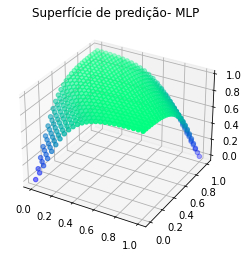

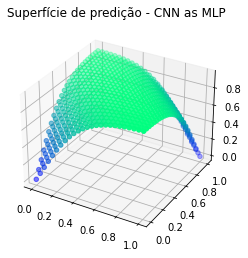

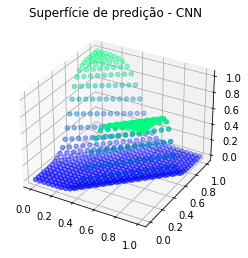

In [ ]:
def buildMLP_xor(auto_grad=False):
  verbose = False
#  verbose = True
  #criando uma rede com uma camada oculta
  layers_xor = [ 
                 Dense(2,3,verbose=verbose, auto_grad=auto_grad),
                 Tanh(verbose=verbose,      auto_grad=auto_grad),
                 Dense(3,1,verbose=verbose, auto_grad=auto_grad),
                 Tanh(verbose=verbose,      auto_grad=auto_grad),
               ]

  #report = Report(transf=Categorical(1), show=False)
  report = None
  return Network(epochs=2500, lr=0.1, loss=MSE(), network=layers_xor, auto_grad=auto_grad, report=report)



def buildCNN_xor_emulating_mlp(auto_grad=False):
  verbose = False
#  verbose = True
  #criando uma rede com uma camada oculta
  layers_xor = [ 
                 Conv2d((2,1,1),1,3,verbose=verbose, auto_grad=auto_grad),
                 Tanh(verbose=verbose,      auto_grad=auto_grad),
                 Conv2d((3,1,1),1,1,verbose=verbose, auto_grad=auto_grad),
                 Tanh(verbose=verbose,      auto_grad=auto_grad),
               ]

  #report = Report(transf=Categorical(1), show=False)
  report = None
  return Network(epochs=2500, lr=0.1, loss=MSE(), network=layers_xor, auto_grad=auto_grad, report=report)



def buildCNN_xor(auto_grad=False):
  verbose = False
#  verbose = True
  #criando uma rede com uma camada oculta
  layers_xor = [ 
                 Conv2d((2,1,1),1,3,verbose=verbose, auto_grad=auto_grad),
                 Sigmoid(verbose=verbose,      auto_grad=auto_grad),
                 Reshape( [3,1,1], [3*1*1], verbose=verbose, auto_grad=auto_grad ),
                 Dense(3,1,verbose=verbose, auto_grad=auto_grad),
                 Sigmoid(verbose=verbose,      auto_grad=auto_grad),
               ]

  #report = Report(transf=Categorical(1), show=False)
  report = None
  return Network(epochs=4000, lr=0.1, loss=BinaryCrossEntropy(), network=layers_xor, auto_grad=auto_grad, report=report)



########################## [ MAIN ] ######################################
Utils.printGPUInfo()

AUTOGRAD=False
mlp = buildMLP_xor(auto_grad=AUTOGRAD)
cnn_as_mlp = buildCNN_xor_emulating_mlp(auto_grad=AUTOGRAD)
cnn = buildCNN_xor(auto_grad=AUTOGRAD)

#X = np.array([[0,1,1,0], [0,1,0,1]], dtype=np.float32)
#Y = np.array([[0,0,1,1]], dtype=np.float32)
X = np.array([[0,0], [1,1], [1,0], [0,1]], dtype=np.float32)  # OK INVERSAO
Y = np.array([[0],[0],[1],[1]], dtype=np.float32)  # OK INVERSAO

Xcnn = np.reshape(X, (4,2,1,1))
Ycnn = np.reshape(Y, (4,1,1,1) )

#treinando a rede (algoritmo offline)
mlp.fit(X, Y, X, Y, minibatch_size=4)
cnn_as_mlp.fit(Xcnn, Ycnn, Xcnn, Ycnn, minibatch_size=4)
cnn.fit(Xcnn, Y, Xcnn, Y, minibatch_size=4, lr=0.5)

#validando
points = []
pointscnn = []
pointscnnasmlp = []
for i in np.linspace(0, 1, 25):
    for j in np.linspace(0, 1, 25):
        y_pred = mlp.predict( np.array([ [i,j] ], dtype=np.float32) )
        points.append([i, j, y_pred[0][0].detach().numpy()])

        y_pred_cnnasmlp = cnn_as_mlp.predict( np.array( [ [ [ [i] ], [ [j] ] ] ], dtype=np.float32)  )   # OK INVERSAO
        pointscnnasmlp.append([i, j, y_pred_cnnasmlp[0][0][0][0].detach().numpy()])

        y_pred_cnn = cnn.predict( np.array( [ [ [ [i] ], [ [j] ] ] ], dtype=np.float32)  )   # OK INVERSAO
        pointscnn.append([i, j, y_pred_cnn[0][0].detach().numpy()])


points = np.array(points)
pointscnn = np.array(pointscnn)
pointscnnasmlp = np.array(pointscnnasmlp)

#visualizando a superfície de predição
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.title("Superfície de predição- MLP")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pointscnnasmlp[:, 0], pointscnnasmlp[:, 1], pointscnnasmlp[:, 2], c=pointscnnasmlp[:, 2], cmap="winter")
plt.title("Superfície de predição - CNN as MLP")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pointscnn[:, 0], pointscnn[:, 1], pointscnn[:, 2], c=pointscnn[:, 2], cmap="winter")
plt.title("Superfície de predição - CNN")
plt.show()


---
##**Teste de Classificação Simples**

Outro teste de sanidade é implementar um problema simples de classificação.

Nesta seção, iremos implementar uma rede que aprenderá a função círculo abaixo definida. Esta função que distingue se um ponto está dentro ou fora de círculo de raio $R$.

$$
\displaystyle 
        circle(x_1,x_2) =  \begin{cases}
                   1, & \sqrt{x_1^2 + x_2^2} > R \\
                   0, & cc
               \end{cases}
$$

A arquitetura da rede proposta segue abaixo: 

First column name    | #Neurônios
---------------------|------------------
Entrada (X)1         | 2
Camada Densa (oculta)| 16
Ativação Tanh 1      | 0
Camada Densa (saída) | 1 
Ativação Tanh 2      | 0



(625, 2) (625, 1)
---------------------------------------------------
[ INFO ] Alterando a taxa de aprendizado de 0.1 para 1.0.
---------------------------------------------------
---------------------------------------------------
[ INFO ] Alterando o tamanho do minibatch de 64 para 64.
---------------------------------------------------
---------------------------------------------------
[[ INICIANDO TREINAMENTO ]]
---------------------------------------------------
    [ EPOCHS ]                300
    [ LEARNING RATE ]         1.0
    [ LOSS FUNCTION ]         Binary Cross-entropy
    [ AUTOGRAD ]              False
    [ NÚMERO DE PARÂMETROS ]  65
    [ DEVICE ]                cpu
    [ X LEN ]                 625
    [ Y LEN ]                 625
    [ MINIBATCH SIZE ]        64
[     0/  300]  [ LOSS ] 0.6831317 - [ ACC ] 0.0000000 ----- [ TOTAL TIME ] train:     0.67 secs, valid:     0.00 secs
[    20/  300]  [ LOSS ] 0.1540730 - [ ACC ] 0.0000000 ----- [ TOTAL TIME ] train:   

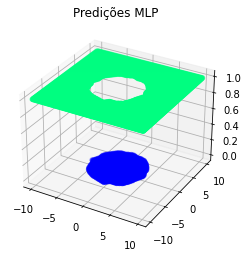

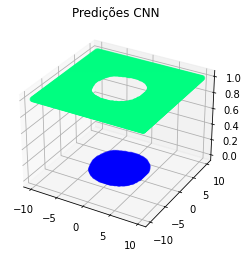

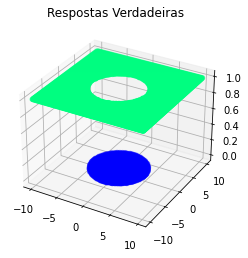

In [ ]:
def buildMLP_regressao(epochs=20000, lr=0.01, auto_grad=False):
  verbose = False
  #criando uma rede com uma camada oculta
  layers = [ 
                 Dense(2,16,verbose=verbose,auto_grad=auto_grad),
                 Tanh(verbose=verbose,auto_grad=auto_grad),
                 Dense(16,1,verbose=verbose,auto_grad=auto_grad),
                 Sigmoid(verbose=verbose,auto_grad=auto_grad),
               ]

  report = None
  return Network(epochs=epochs, lr=lr, loss=MSE(), network=layers,auto_grad=auto_grad, report=report, minibatch_size=64)



def buildCNN_regressao(epochs=20000, lr=0.01, auto_grad=False):
  verbose = False
  #criando uma rede com uma camada oculta
  layers = [ 
                 Conv2d((2,1,1),1,16,verbose=verbose, auto_grad=auto_grad),
                 Sigmoid(verbose=verbose,auto_grad=auto_grad),
                 Reshape([16,1,1],[16*1*1],verbose=verbose, auto_grad=auto_grad),
                 Dense(16,1,verbose=verbose,auto_grad=auto_grad),
                 Sigmoid(verbose=verbose,auto_grad=auto_grad)
               ]
  report = None
  return Network(epochs=epochs, lr=lr, loss=BinaryCrossEntropy(), network=layers,auto_grad=auto_grad, report=report, minibatch_size=64)



def geraDadosCirculo(raio=1, nx1=24, nx2=24):
  from keras.utils import np_utils

  NX1=nx1
  NX2=nx2
  
  input1=np.zeros((NX1*NX2,2), dtype=np.float32)
  output=np.zeros((NX1*NX2,1), dtype=np.float32)

  X1 = np.linspace(XMIN,XMAX, NX1, dtype=np.float32)
  X2 = np.linspace(XMIN,XMAX, NX2, dtype=np.float32)

  idx=0
  for x1 in X1:
    for x2 in X2:
      input1[idx,0] = x1
      input1[idx,1] = x2

      d = np.sqrt(x1*x1 + x2*x2)
      if d > raio:
        output[idx,0] = 0.0
      else:
        output[idx,0] = 1.0
      idx = idx+1


  #return np.array( input1, dtype=np.float32), np.array(output, dtype=np.float32)
  return input1, output



########################## [ MAIN ] ######################################

XMIN=-10
XMAX=-XMIN
AUTOGRAD=False
#AUTOGRAD=True
raio = XMAX/2.
nx1=25
nx2=25

mlp = buildMLP_regressao(epochs=300, lr=0.1, auto_grad=AUTOGRAD)
cnn = buildCNN_regressao(epochs=300, lr=0.1, auto_grad=AUTOGRAD)

X,Y = geraDadosCirculo(raio=raio, nx1=nx1, nx2=nx2)

Xcnn = np.reshape(X, (nx1*nx2,2,1,1))
Ycnn = np.reshape(Y, (nx1*nx2,1,1,1) )
print(X.shape, Y.shape)

#treinando a rede (algoritmo offline)
cnn.fit(Xcnn, Y, Xcnn, Y, minibatch_size=64, lr=1.) #OBS.: Não está sendo feita validação, pois é apenas um teste.
mlp.fit(X, Y, X, Y, minibatch_size=64, lr=0.7) #OBS.: Não está sendo feita validação, pois é apenas um teste.

x = np.linspace(XMIN,XMAX,100)

points = []
pointscnn = []
for x1 in x:
  for x2 in x:
    y_pred = mlp.predict( np.array([ [x1, x2] ], dtype=np.float32) )
    y_pred = 0. if y_pred[0,0] > 0.5 else 1.
    points.append([x1, x2, y_pred])
    y_pred = cnn.predict( np.array( [ [ [ [x1] ], [ [x2] ] ] ], dtype=np.float32)  )   # OK INVERSAO
    y_pred = 0. if y_pred[0,0] > 0.5 else 1.
    pointscnn.append([x1, x2, y_pred])
points = np.array(points)
pointscnn = np.array(pointscnn)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.title("Predições MLP")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pointscnn[:, 0], pointscnn[:, 1], pointscnn[:, 2], c=pointscnn[:, 2], cmap="winter")
plt.title("Predições CNN")
plt.show()

points = []
for x1 in x:
  for x2 in x:
    y_pred=1
    if np.sqrt(x1*x1+x2*x2) <= raio:
      y_pred=0
    points.append([x1, x2, y_pred])

points = np.array(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.title("Respostas Verdadeiras")
plt.show()


##**MNIST**

A base de dados MNIST (Modified National Institute of Standards and Technology database) é uma extensa base de dados de imagens que contém os algarismos arábicos de 0 a 9 escritos à mão.

É uma base de dados padrão amplamente utilizada para avaliação de algoritmos de processamento de imagens e machine learning.

As imagens do banco de dados foram pré-processadas e reamostradas para uma dimensão fixa de 28x28 pixels com anti-álias, gerando imagens em tons de cinza, com fundo preto e o algarismo em branco.

---
###**Lendo os dados**
Será utilizada a biblioteca Keras para ler os dados.

---
###**Dados de treino, validação e teste**

A biblioteca Keras entrega os dados divididos em dados de treino e dados de teste. 

Os dados de teste são utilizados para avaliar a qualidade do classificador após todo o processo de treinamento e ajuste de hiper-parâmetros. **Os dados de teste possuem 10.000 imagens.**

Os dados de treino são utilizados para o treinamento e para a validação do laço de treinamento. Os dados de treino entregues pelo Keras possuem 60.000 imagens. Neste trabalho, estamos utilizando **50.000 para treino e 10.000 para validação**.

---
###**Visualizando os dados**
Uma grade com os 25 primeiros dados de entrada será visualizada juntamente com seus labels.

A base de dados MNIST entregue pela biblioteca Keras já se encontra bem distribuída entre suas classes e embaralhada.  

**Obs.:** Apesar da base de dados ter amostras bem distribuídas entre as classes e estar embaralhada, a rede neural aqui implementada realiza um novo embaralhamento a cada época de treinamento.

[ TEMPO ] Carregando dado: 0.22430896759033203 sec
[ INFO ] Qtd. de imagens de treino: 60000
[ INFO ] Qtd. de imagens de teste: 10000
[ INFO ] Dimensões da imagem: 28x28


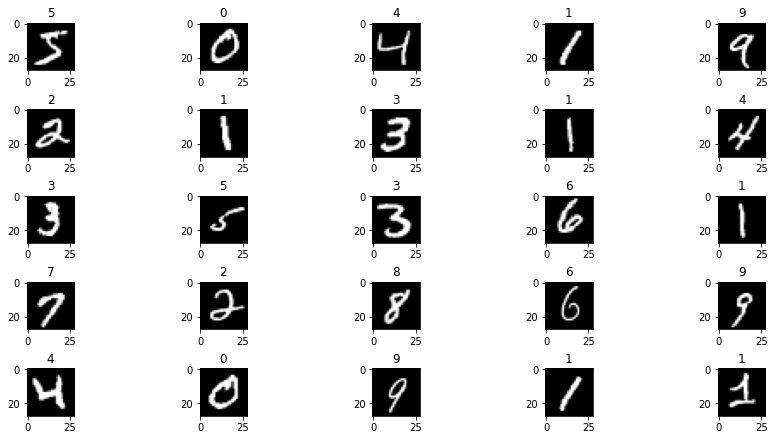

In [ ]:
from keras.datasets import mnist
from keras.utils import np_utils


# load MNIST from server

t_start = time.time()
(x_train_o_tt, y_train_o_tt), (x_test_o, y_test_o) = mnist.load_data()
t_end = time.time()
print(f"[ TEMPO ] Carregando dado: {t_end-t_start} sec")
print(f"[ INFO ] Qtd. de imagens de treino: {len(x_train_o_tt)}")
print(f"[ INFO ] Qtd. de imagens de teste: {len(x_test_o)}")
print(f"[ INFO ] Dimensões da imagem: {x_test_o.shape[1]}x{x_test_o.shape[2]}")

x_train_o = x_train_o_tt[:50000]
y_train_o = y_train_o_tt[:50000]
x_valid_o = x_train_o_tt[50000:] 
y_valid_o = y_train_o_tt[50000:] 

# visualizando os 25 primeiros dados de entrada

fig = plt.figure(figsize=(Utils.PLOT_SX*2,Utils.PLOT_SY), constrained_layout=True)
gs = fig.add_gridspec(5, 5)
for i in range(0,25):
  ax = fig.add_subplot(gs[i//5, i%5])
  Utils.drawImageAttr_grid(ax, x_train_o[i])
  ax.set_title(f"{y_train_o[i]}")
plt.show()




###**Criação da rede neural**

A proposta do trabalho é implementar uma rede neural CNN para resolver o problema de identificação de algarismos arábicos do MNIST.

Abaixo, segue a arquitetura da rede proposta:

First column name    | #Parâmetros
---------------------|------------------
Conv2d               |  
Relu                 |
MaxPool2d            |
Conv2d               |
Relu                 |
MaxPool2d            |
Conv2d               |
Relu                 |
Reshape              |
Dense                |
Sigmoid              |
Softmax              |
           Total     | 448



In [ ]:

def buildMLP_MNIST_1CamadaOculta(nw=40, epochs=1000, lr=0.01, auto_grad=False,dtype=torch.float32, show=False, report=None, device='cpu', loss=MSE() ):
  #criando uma rede com uma camada oculta
  layers = [ 
    Dense(28*28, nw, auto_grad=auto_grad, dtype=dtype, device=device),
    Tanh(auto_grad=auto_grad, dtype=dtype, device=device),
    Dense(nw, 10, auto_grad=auto_grad, dtype=dtype, device=device),
    Tanh(auto_grad=auto_grad, device=device)
    #Sigmoid(auto_grad=auto_grad, device=device)
           ]
  
  return Network(epochs=epochs, lr=lr, loss=loss, network=layers, auto_grad=auto_grad, report=report, device=device)



def buildCNN_MNIST_1CamadaOculta(nw=2, epochs=1000, lr=0.01, auto_grad=False,dtype=torch.float32, verbose=False, show=False, report=None, device='cpu', loss=MSE() ):
  #criando uma rede com uma camada oculta
  layers = [ 
    Conv2d( (1,28,28), 2, nw, auto_grad=auto_grad, dtype=dtype, device=device, verbose=verbose),
    Relu(auto_grad=auto_grad, dtype=dtype, device=device, verbose=verbose),
    MaxPool2d( (nw,27,27), 2, verbose=verbose, auto_grad=auto_grad, device=device, dtype=dtype),
    Conv2d( (nw,14,14), 2, 1, auto_grad=auto_grad, dtype=dtype, device=device, verbose=verbose),
    Relu(auto_grad=auto_grad, device=device, verbose=verbose),
    MaxPool2d( (1,13,13), 2, verbose=verbose, auto_grad=auto_grad, device=device, dtype=dtype),
    Conv2d( (1,7,7), 2, 1, auto_grad=auto_grad, dtype=dtype, device=device, verbose=verbose),
    Relu(auto_grad=auto_grad, device=device, verbose=verbose),
    Reshape([1,6,6],[1*6*6], auto_grad=auto_grad, dtype=dtype, device=device, verbose=verbose),
    Dense(6*6, 10, auto_grad=auto_grad, dtype=dtype, device=device, verbose=verbose),
    Sigmoid(auto_grad=auto_grad, dtype=dtype, device=device, verbose=verbose),
    Softmax(auto_grad=auto_grad, device=device, verbose=verbose)
           ]

  return Network(epochs=epochs, lr=lr, loss=loss, network=layers, auto_grad=auto_grad, report=report, device=device)


t_start = time.time()
mlp = buildMLP_MNIST_1CamadaOculta(nw=40, epochs=200, lr=0.01, auto_grad=False, report=None,show=False, device='cpu')#Utils.getTensorDevice())#device='cpu')
t_end = time.time()
print(f"[ ------------ MLP ------------]")
print(f"[ TEMPO ] Criando rede: {t_end-t_start} secs")

print(f"[ INFO ] A quantidade de parâmetros da rede é: { mlp.size()} ")
print(f"[ INFO ] O device utilizado é: { mlp.device} ")


t_start = time.time()
cnn = buildCNN_MNIST_1CamadaOculta(nw=2, epochs=200, lr=0.01, loss=CategoricalCrossEntropy(), auto_grad=False, report=None,show=False, device='cpu')#Utils.getTensorDevice())#device='cpu')
t_end = time.time()
print(f"[ ------------ CNN ------------]")
print(f"[ TEMPO ] Criando rede: {t_end-t_start} secs")

print(f"[ INFO ] A quantidade de parâmetros da rede é: { cnn.size()} ")
print(f"[ INFO ] O device utilizado é: { cnn.device} ")

[ ------------ MLP ------------]
[ TEMPO ] Criando rede: 0.00037479400634765625 secs
[ INFO ] A quantidade de parâmetros da rede é: 31810 
[ INFO ] O device utilizado é: cpu 
[ ------------ CNN ------------]
[ TEMPO ] Criando rede: 0.000209808349609375 secs
[ INFO ] A quantidade de parâmetros da rede é: 448 
[ INFO ] O device utilizado é: cpu 


---
### **Espaço de hiper-parâmetros**
**OS RESULTADOS OBTIDOS A PARTIR DESSA SEÇÃO ESTÃO INCOMPLETOS E SERÃO MELHORADOS.**

---

####**Busca por hiper-parâmetros**

Esta versão corrente do ORN não está conseguindo bons resultados com o MNIST. Então, não foi possível realizar a busca exaustiva por hiper-parâmetros.

No momento, apenas algumas poucas configurações de hiper-parâmetros foram testadas manualmente.

A melhor delas está sendo mostrada nas duas células de execução abaixo.


In [ ]:

def preprocess_data(x_, y_, limit=None, transf=Categorical(10)):

    if limit is None:
      limit = x.shape[0]

    x = x_.copy()
    y = y_.copy()

    # normalize input data
    x = x.reshape(x.shape[0], 1, 28, 28)
    x = x[:limit]
    x = x.astype("float32") / 255
    # encode output which is a number in range [0,9] into a vector of size 10
    # e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    num_categories = 10
    y = transf.to_categorical(y)
    y = y.reshape(y.shape[0], num_categories)
    y = y[:limit]
    
    return x, y #np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)


def runTestCNN(nepochs, lr, minibatch_size, auto_grad=True, show=False, verbose=False, device='cpu', report=Report(transf=Categorical(10))):
  print(f'[ RUN - CNN ] nepochs = {nepochs}, lr = {lr}, minibatch_size = {minibatch_size}')
  cnn = buildCNN_MNIST_1CamadaOculta(nw=2, epochs=nepochs, lr=lr, loss=CategoricalCrossEntropy(), verbose=verbose, auto_grad=auto_grad, report=report,show=show, device=device)#Utils.getTensorDevice())#device='cpu')
  global x_train, y_train, x_valid, y_valid
  x_train_cnn = np.reshape(x_train, (x_train.shape[0], 1, 28, 28))
  print("x_train_cnn.shape = ", x_train_cnn.shape)
  loss, accuracy, t_time = cnn.fit(x_train_cnn, y_train, x_valid, y_valid, lr=lr, minibatch_size=minibatch_size, verbose=True)
  return cnn, loss, accuracy, t_time


def runTest(nepochs, lr, minibatch_size, auto_grad=True, show=False, verbose=False, device='cpu', report=Report(transf=Categorical(10))):
  print(f'[ RUN ] nepochs = {nepochs}, lr = {lr}, minibatch_size = {minibatch_size}')
  mlp = buildMLP_MNIST_1CamadaOculta(nw=40, epochs=nepochs, lr=lr, auto_grad=auto_grad, report=report,show=show, device=device)#Utils.getTensorDevice())#device='cpu')
  global x_train, y_train, x_valid, y_valid
  loss, accuracy, t_time = mlp.fit(x_train, y_train, x_valid, y_valid, lr=lr, minibatch_size=minibatch_size, verbose=verbose)
  return mlp, loss, accuracy, t_time


def runSuite(vepochs, vlr, vmini, auto_grad=True, show=False, verbose=False, device='cpu', code=True, report=Report(transf=Categorical(10))):

    results = {}
    print(f"[ INFO ] Qtd. de testes: {vepochs.shape[0]*vlr.shape[0]*vmini.shape[0]}")
    
    t_start = time.time()
    
    best_accuracy=None
    cont=0
    for i,e in enumerate(vepochs):
      results[e] = {}
      for j,l in enumerate(vlr):
        results[e][l] = {}
        for k,m in enumerate(vmini):
    
          mlp, loss, accuracy, t_time = runTestCNN(e,l,m,auto_grad=auto_grad, show=show, verbose=verbose, device=device, report=report) 
    
          if best_accuracy is None or accuracy > best_accuracy["acc"]:
            best_accuracy = { 
                'loss': loss, 'acc': accuracy, 'tempo':t_time,
                'epoch':e, 'lr': l, 'mini':m
            }
            print("[ BEST ACCURACY ] ", best_accuracy)
    
          results[e][l][m] = [loss, accuracy, t_time]
          print(f"[ {cont} ] loss={loss}, acc={accuracy}, tempo treinamento={t_time} secs")
          if code:
            print(f"[ CODE ] e = {e}; l = {l}; m = {m}")
            print(f"[ CODE ] insere_elemento(tab_resultados, e=e, l=l, m=m, loss={loss}, acc={accuracy}, tempo={t_time})" )
          cont  = cont + 1
    
    t_end = time.time()
    print("[ BEST ACCURACY ] ", best_accuracy)
    print("[ TOTAL TIME ] ", t_end-t_start, " secs")

    return results



#################################################################3


DTYPE=torch.float32
transf = Categorical(10)

t_start = time.time()
x_train, y_train  = preprocess_data(x_train_o, y_train_o, limit=50000, transf=transf)
x_valid, y_valid = preprocess_data(x_valid_o, y_valid_o, limit=10000, transf=transf) #observacao: para o dado de teste, somente está funcionando minibatch=1
x_test, y_test = preprocess_data(x_test_o, y_test_o, limit=10000, transf=transf) #observacao: para o dado de teste, somente está funcionando minibatch=1
t_end = time.time()
print(f"[ TEMPO ] Preprocessando o dado: {t_end-t_start} secs")




[ TEMPO ] Preprocessando o dado: 0.0641794204711914 secs


[ INFO ] Qtd. de testes: 1
[ RUN - CNN ] nepochs = 500, lr = 0.1, minibatch_size = 1024
x_train_cnn.shape =  (50000, 1, 28, 28)
---------------------------------------------------
[ INFO ] Alterando a taxa de aprendizado de 0.1 para 0.1.
---------------------------------------------------
---------------------------------------------------
[ INFO ] Alterando o tamanho do minibatch de 1 para 1024.
---------------------------------------------------
---------------------------------------------------
[[ INICIANDO TREINAMENTO ]]
---------------------------------------------------
    [ EPOCHS ]                500
    [ LEARNING RATE ]         0.1
    [ LOSS FUNCTION ]         Categorical Cross-entropy
    [ AUTOGRAD ]              False
    [ NÚMERO DE PARÂMETROS ]  448
    [ DEVICE ]                cpu
    [ X LEN ]                 50000
    [ Y LEN ]                 50000
    [ MINIBATCH SIZE ]        1024
[     0/  500]  [ LOSS ] 2.3493803 - [ ACC ] 0.1092000 ----- [ TOTAL TIME ] train

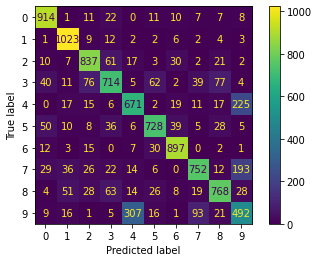

[ BEST ACCURACY ]  {'loss': 1.6468638181686401, 'acc': 0.7796, 'tempo': 8666.485560655594, 'epoch': 500, 'lr': 0.1, 'mini': 1024}
[ 0 ] loss=1.6468638181686401, acc=0.7796, tempo treinamento=8666.485560655594 secs
[ CODE ] e = 500; l = 0.1; m = 1024
[ CODE ] insere_elemento(tab_resultados, e=e, l=l, m=m, loss=1.6468638181686401, acc=0.7796, tempo=8666.485560655594)
[ BEST ACCURACY ]  {'loss': 1.6468638181686401, 'acc': 0.7796, 'tempo': 8666.485560655594, 'epoch': 500, 'lr': 0.1, 'mini': 1024}
[ TOTAL TIME ]  8848.891629695892  secs
---------------------------------------------------------------
---------------------------------------------------------------
---------------------------------------------------------------


In [ ]:
# OBSERVAÇÃO:
#
# Esta célula implementa a busca por hiper-parâmetros.
# Sua execução durou um pouco mais de 6 horas no total, mas foi interrompida diversas vezes.
# Por isso, os resultados parciais eram salvos a cada teste realizado.
#

#vepochs=np.array([50, 100, 200])
#vlr=np.array([1., 0.1, 0.01] )
#vmini=np.array([4, 32, 1000])
vepochs=np.array([500])
vlr=np.array([0.1])
vmini=np.array([1024])

#from torch import autograd
#with autograd.detect_anomaly(check_nan=True):
#  runSuite(vepochs, vlr, vmini, auto_grad=True, show=True, verbose=False, device='cpu', code=True)
runSuite(vepochs, vlr, vmini, auto_grad=False, show=True, verbose=False, device='cpu', code=True)

print("---------------------------------------------------------------")
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")

#runSuite(vepochs, vlr, vmini, auto_grad=True, show=False, verbose=False, device='cpu', code=True)



---
####**Análise da busca de hiper-parâmetros**

**Observação:** Com 500 épocas (duas horas e meia de processamento), conseguiu-se o melhor resultado até agora: **78% de acurácia** no dado de validação. Mas esse resultado ainda está muito abaixo do esperado. Isso aponta para alguma problema na rede implementada. Talvez, algum erro no cálculo de algum gradiente.

---
**ESTE TRABALHO SERÁ CONTINUADO.**
---


---

### **Treinamento**

####**Treinamento com AUTO_GRAD=True**

**A REALIZAR.** 

In [ ]:
report = Report(transf=transf)
mlp, loss, accuracy, t_time = runTest(400, 0.1, 4, auto_grad=True, device='cpu', show=True, verbose=True, report=report) 
report.printCurves()

####**Treinamento com AUTO_GRAD=False**
**A REALIZAR.**

In [ ]:
report_2 = Report(transf=transf)
mlp_2, loss, accuracy, t_time = runTest(400, 0.01, 4, auto_grad=False, device='cpu', show=True, verbose=True, report=report_2) 
report_2.printCurves()

###**Teste final do classificador**
**A REALIZAR.**

---
# **Melhorias para Entrega Complementar**
Durante a apresentação do ORN em sala de aula, foram sugeridas algumas mudanças:
 - Criar dois *notebooks*
  - o **primeiro** explicando o ***framework*** e mostrando apenas as camadas importantes para criar uma rede **MLP**
  - o **segundo estende** o *framework*, acrescentando as camadas necessárias para se implementar um rede **CNN**